## Deep Learning & Image Classification Setup
### Importing Libraries 

In [1]:
import os
import shutil
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
from tqdm import tqdm
from PIL import Image
import seaborn as sns
import sklearn
from tensorflow.keras.applications import *
from tensorflow.keras.layers import Flatten, Dense, Input, Dropout, GlobalAveragePooling2D,BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.efficientnet_v2 import preprocess_input as base_preprocess
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ModelCheckpoint
from sklearn.utils import class_weight
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc,precision_recall_curve, average_precision_score
from sklearn.preprocessing import label_binarize

## Dataset Paths and Directory Setup

In [2]:
images_dir = "/kaggle/input/skin-dataset/skin/HAM10000_data"
csv_path = "/kaggle/input/skin-dataset/skin/HAM10000_metadata.csv"
data_images_dir='/kaggle/working/Images'
data_images_tmp='/kaggle/working/tmp'


## Hair Removal & Image Preprocessing
### To improve model performance on dermatoscopic images, this script removes hair artifacts using OpenCV techniques before saving the cleaned images to a temporary directory.

In [3]:
def preprocess(image):
    try:
        grayScale = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
        kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (17, 17))
        blackhat = cv2.morphologyEx(grayScale, cv2.MORPH_BLACKHAT, kernel)
        _, threshold = cv2.threshold(blackhat, 10, 255, cv2.THRESH_BINARY)
        final_image = cv2.inpaint(image, threshold, 1, cv2.INPAINT_TELEA)
        gaussian = cv2.GaussianBlur(final_image, (0, 0), 2.0)
        return cv2.addWeighted(image, 1.5, gaussian, -0.5, 0)
        return final_image
    except Exception as e:
        print(f"Error in hair removal: {str(e)}")
        return image


In [4]:
input_dir = images_dir
output_dir = data_images_tmp
os.makedirs(output_dir, exist_ok=True)

images = os.listdir(input_dir)

for image_name in tqdm(images):
    input_path = os.path.join(input_dir, image_name)
    output_path = os.path.join(output_dir, image_name)

    image = cv2.imread(input_path)

    if image is None:
        print(f"Failed to read: {input_path}")
        continue

    processed = preprocess(image)

    processed_rgb = cv2.cvtColor(processed, cv2.COLOR_BGR2RGB)
    Image.fromarray(processed_rgb).save(output_path)


100%|██████████| 10015/10015 [09:35<00:00, 17.42it/s]


## Organizing Images by Class Labels
### Images are organized into directories named after their diagnostic class (`dx`) for easier loading with image generators or datasets.

In [5]:
%system rm -rf $data_images_dir
%system mkdir $data_images_dir

df = pd.read_csv(csv_path)
    
for _, row in df.iterrows():
    image_id = row["image_id"] + ".jpg" 
    class_name = row["dx"]
    
    class_dir = os.path.join(data_images_dir, class_name)
    os.makedirs(class_dir, exist_ok=True)
    
    src_path = os.path.join(data_images_tmp, image_id)
    dst_path = os.path.join(class_dir, image_id)
    
    if os.path.exists(src_path):
        shutil.copy(src_path, dst_path)

print("Images have been successfully organized into class directories!")

Images have been successfully organized into class directories!


## Handling Class Imbalance: Class Weights

In [6]:
class_labels = np.unique(df["dx"])

class_weights = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=class_labels,
    y=df["dx"]
)

class_wt_dict = dict(enumerate(class_weights))
class_wt_dict_labels = dict(zip(class_labels, class_weights))

print(class_wt_dict)
print(class_wt_dict_labels)

{0: 4.375273044997815, 1: 2.78349082823791, 2: 1.301832835044846, 3: 12.440993788819876, 4: 1.2854575792581184, 5: 0.21338020666879728, 6: 10.075452716297788}
{'akiec': 4.375273044997815, 'bcc': 2.78349082823791, 'bkl': 1.301832835044846, 'df': 12.440993788819876, 'mel': 1.2854575792581184, 'nv': 0.21338020666879728, 'vasc': 10.075452716297788}


## Image Data Augmentation 
-  Preprocessing based on base model (EfficientNetV2)
-  Random rotation 
-  Horizontal shift 
-  Vertical shift 
-  Shear transformation
-  Random zoom
-  Random brightness adjustment
-  Small changes in RGB channels
-  Random horizontal flips
-  Fill strategy for empty pixels after transformations
-  15% of data reserved for validation

In [7]:
image_gen = ImageDataGenerator(
                               preprocessing_function=base_preprocess,
                               rotation_range=30,
                               width_shift_range=0.1,
                               height_shift_range=0.1,
                               shear_range=0.1,
                               zoom_range=0.2,
                               brightness_range=[0.9,1.1],
                               channel_shift_range=0.05,
                               horizontal_flip=True,
                               fill_mode='nearest',
                               validation_split=0.15)

## Data Generators for Training and Validation

In [8]:
batch_size = 32
target_size = (299,299)
train_image_gen = image_gen.flow_from_directory(data_images_dir, 
                                          target_size=target_size,
                                          color_mode='rgb',
                                          batch_size=batch_size,
                                          class_mode='categorical',
                                          subset="training")

test_image_gen = image_gen.flow_from_directory(data_images_dir, 
                                          target_size=target_size, 
                                          color_mode='rgb',
                                          batch_size=batch_size,
                                          class_mode='categorical',
                                          shuffle=False,
                                          subset="validation")

print(test_image_gen.class_indices)

Found 8516 images belonging to 7 classes.
Found 1499 images belonging to 7 classes.
{'akiec': 0, 'bcc': 1, 'bkl': 2, 'df': 3, 'mel': 4, 'nv': 5, 'vasc': 6}


## Visualizing a Sample Image from the Training Generator

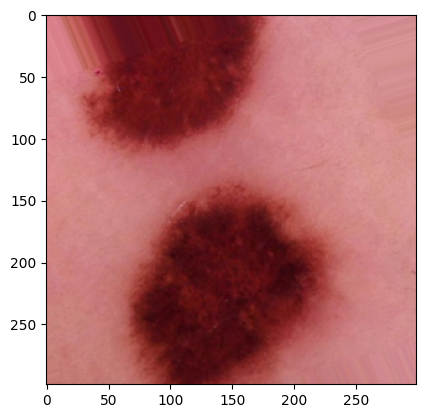

In [9]:
plt.imshow(train_image_gen[0][0][0]/255)

## Model Architecture: Transfer Learning with ResNet50V2

### We leverage **ResNet50V2**, a highly efficient and high-performing convolutional neural network, pretrained on ImageNet. The base is extended with a custom classification head tailored for the 7 skin lesion categories in the HAM10000 dataset.

In [10]:
base_model = ResNet50V2(weights='imagenet', include_top=False, input_shape=(299, 299, 3))
base_model.trainable=True

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(128,kernel_regularizer='l2',activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(7, activation='softmax')(x)
model = Model(inputs=base_model.input, outputs=x)

94668760/94668760 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


## Model Summary: ResNet50V2 + Custom Classifier

In [11]:
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 299, 299, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_pad (ZeroPadding2D) │ (None, 305, 305, 3)    │              0 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_conv (Conv2D)       │ (None, 150, 150, 64)   │          9,472 │ conv1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pad (ZeroPadding2D) │ (None, 152, 152, 64)   │              0 │ conv1_conv[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pool (MaxPooling2D) │ (None, 75, 75, 64)     │              0 │ pool1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_preact_bn    │ (None, 75, 75, 64)     │            256 │ pool1_pool[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_preact_relu  │ (None, 75, 75, 64)     │              0 │ conv2_block1_preact_b… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_conv       │ (None, 75, 75, 64)     │          4,096 │ conv2_block1_preact_r… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_bn         │ (None, 75, 75, 64)     │            256 │ conv2_block1_1_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_relu       │ (None, 75, 75, 64)     │              0 │ conv2_block1_1_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_pad        │ (None, 77, 77, 64)     │              0 │ conv2_block1_1_relu[0… │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_conv       │ (None, 75, 75, 64)     │         36,864 │ conv2_block1_2_pad[0]… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_bn         │ (None, 75, 75, 64)     │            256 │ conv2_block1_2_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_relu       │ (None, 75, 75, 64)     │              0 │ conv2_block1_2_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_0_conv       │ (None, 75, 75, 256)    │         16,640 │ conv2_block1_preact_r… │
│ (Conv2D)             

 Total params: 23,827,975 (90.90 MB)

 Trainable params: 23,782,535 (90.72 MB)

 Non-trainable params: 45,440 (177.50 KB)

## Model Compilation

In [17]:
optimizer = Adam(0.0001)
model.compile(loss="categorical_crossentropy", optimizer=optimizer, metrics=["accuracy"])

## Callbacks for Efficient Training

In [18]:
lr_reduce = ReduceLROnPlateau(monitor='val_accuracy', factor=0.1, patience=2,mode='max', min_lr=0.00000001,verbose=1)
early_stop = EarlyStopping(monitor="val_loss", patience=5, verbose=1)
model_chkpt = ModelCheckpoint('best_model.keras',save_best_only=True, monitor='val_accuracy',verbose=1)

callback_list = [model_chkpt,lr_reduce,early_stop]

## Training the Model

In [19]:
%%time
history = model.fit(train_image_gen,
                    epochs=30, 
                    validation_data = test_image_gen,
                    class_weight=class_wt_dict,
                    callbacks=callback_list)

Epoch 1/30
267/267 ━━━━━━━━━━━━━━━━━━━━ 0s 857ms/step - accuracy: 0.7025 - loss: 1.4903
Epoch 1: val_accuracy improved from -inf to 0.74583, saving model to best_model.keras
267/267 ━━━━━━━━━━━━━━━━━━━━ 323s 1s/step - accuracy: 0.7025 - loss: 1.4903 - val_accuracy: 0.7458 - val_loss: 1.4707 - learning_rate: 1.0000e-04
Epoch 2/30
267/267 ━━━━━━━━━━━━━━━━━━━━ 0s 779ms/step - accuracy: 0.7110 - loss: 1.2844
Epoch 2: val_accuracy did not improve from 0.74583
267/267 ━━━━━━━━━━━━━━━━━━━━ 249s 911ms/step - accuracy: 0.7110 - loss: 1.2843 - val_accuracy: 0.6945 - val_loss: 1.4665 - learning_rate: 1.0000e-04
Epoch 3/30
267/267 ━━━━━━━━━━━━━━━━━━━━ 0s 771ms/step - accuracy: 0.7158 - loss: 1.1278
Epoch 3: val_accuracy did not improve from 0.74583

Epoch 3: ReduceLROnPlateau reducing learning rate to 9.999999747378752e-06.
267/267 ━━━━━━━━━━━━━━━━━━━━ 248s 909ms/step - accuracy: 0.7157 - loss: 1.1278 - val_accuracy: 0.6851 - val_loss: 1.3684 - learning_rate: 1.0000e-04
Epoch 4/30
267/267 ━━━━━━━━

## Plotting Training and Validation Loss

<Axes: >

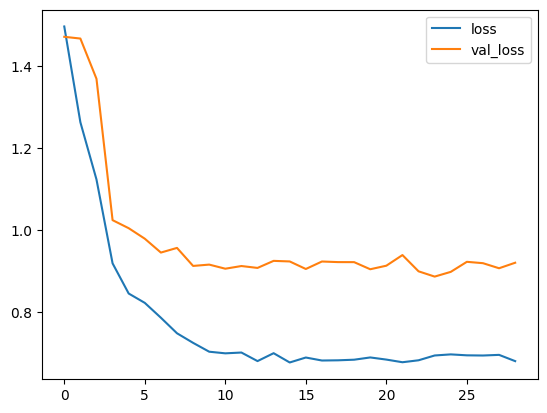

In [20]:
metrics = pd.DataFrame(model.history.history)
metrics[["loss","val_loss"]].plot()

## Plotting Training and Validation Accuracy

<Axes: >

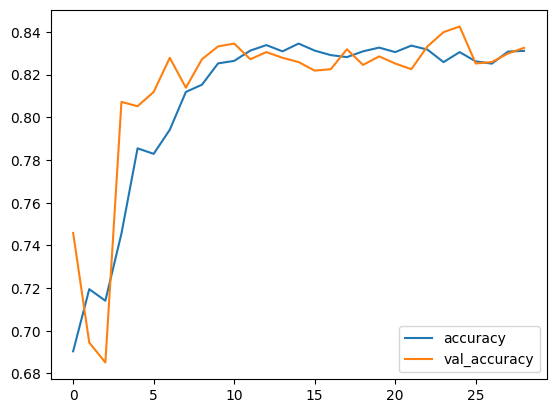

In [21]:
metrics[["accuracy","val_accuracy"]].plot()

## Model Evaluation

In [10]:
model.evaluate(test_image_gen)

/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


47/47 ━━━━━━━━━━━━━━━━━━━━ 55s 886ms/step - accuracy: 0.7993 - loss: 1.0543


[0.9247212409973145, 0.8292194604873657]

## Making Predictions and Evaluating Model Output

In [11]:
y_score = model.predict(test_image_gen, verbose=1)
predictions = y_score.argmax(axis=1)

test_labels = test_image_gen.classes

47/47 ━━━━━━━━━━━━━━━━━━━━ 40s 781ms/step


## Confusion Matrix

In [12]:
cm = confusion_matrix(test_labels, predictions)
print(cm)

[[ 35   3   4   2   4   1   0]
 [  2  68   3   0   1   2   1]
 [  5   3 127   1  14  14   0]
 [  2   0   0  15   0   0   0]
 [  4   4  16   0 113  24   5]
 [  4  19  31   6  65 877   3]
 [  0   1   0   0   0   0  20]]


## Normalized Confusion Matrix

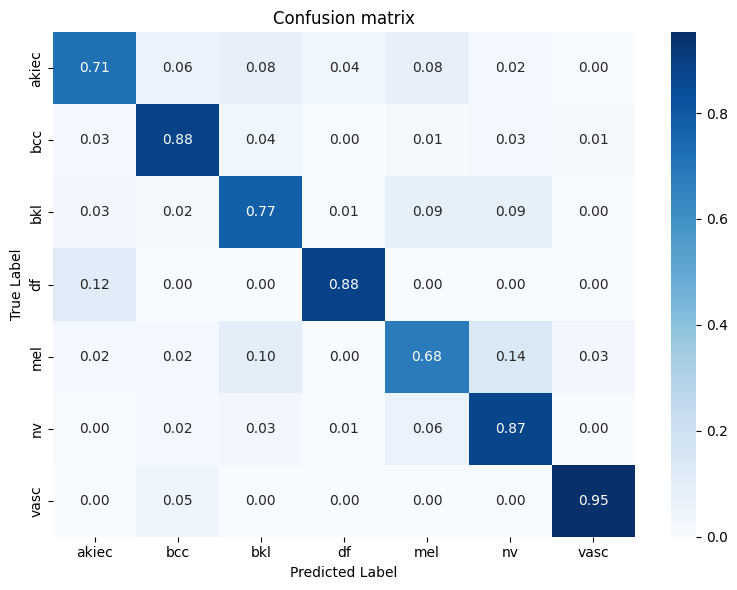

In [13]:
cm_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
classes=list(test_image_gen.class_indices.keys())
plt.figure(figsize=(8, 6))
sns.heatmap(cm_norm, annot=True, fmt='.2f', cmap='Blues', 
            xticklabels=classes, yticklabels=classes, cbar=True)
plt.title('Confusion matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.tight_layout()
plt.show()

## Classification Report

In [14]:
print(classification_report(test_image_gen.classes, predictions, zero_division=0))

              precision    recall  f1-score   support

           0       0.67      0.71      0.69        49
           1       0.69      0.88      0.78        77
           2       0.70      0.77      0.74       164
           3       0.62      0.88      0.73        17
           4       0.57      0.68      0.62       166
           5       0.96      0.87      0.91      1005
           6       0.69      0.95      0.80        21

    accuracy                           0.84      1499
   macro avg       0.70      0.82      0.75      1499
weighted avg       0.86      0.84      0.84      1499



## ROC AUC Score Calculation for Multi-class Classification

In [15]:
class_names = list(test_image_gen.class_indices.keys())
n_classes = len(class_names)

y_test_bin = label_binarize(test_labels, classes=list(range(n_classes)))

fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

for i in range(n_classes):
    print(f"ROC AUC Score for Class {class_names[i]}: AUC = {roc_auc[i]:.4f}")

ROC AUC Score for Class akiec: AUC = 0.9719
ROC AUC Score for Class bcc: AUC = 0.9924
ROC AUC Score for Class bkl: AUC = 0.9571
ROC AUC Score for Class df: AUC = 0.9680
ROC AUC Score for Class mel: AUC = 0.9189
ROC AUC Score for Class nv: AUC = 0.9651
ROC AUC Score for Class vasc: AUC = 0.9995


## Plot ROC AUC  curves for all classes

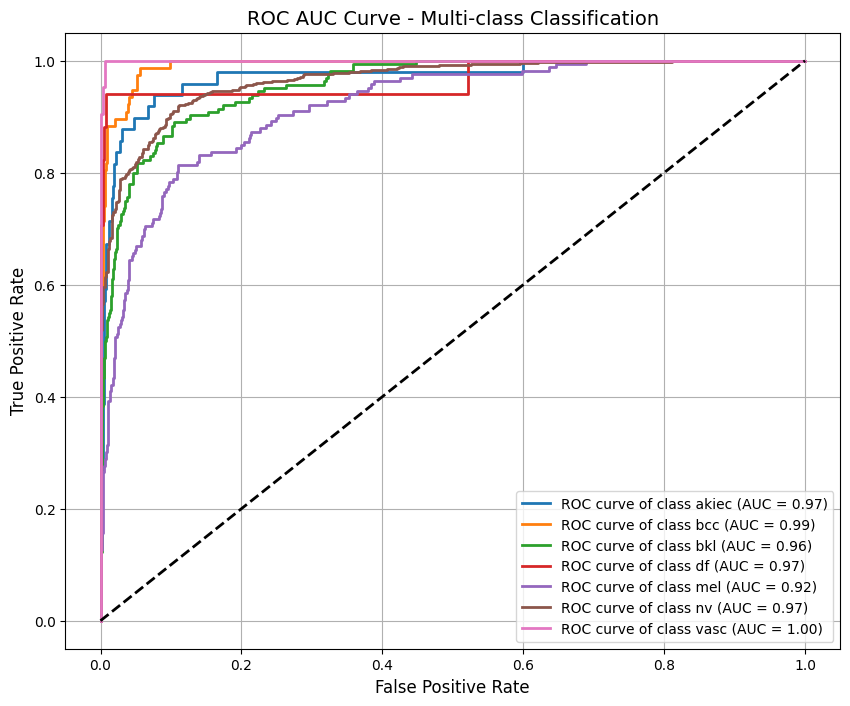

In [16]:
plt.figure(figsize=(10, 8))

for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], lw=2,
             label=f'ROC curve of class {class_names[i]} (AUC = {roc_auc[i]:.2f})')
    
plt.plot([0, 1], [0, 1], 'k--', lw=2)  
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title('ROC AUC Curve - Multi-class Classification', fontsize=14)
plt.legend(loc="lower right", fontsize=10)
plt.grid(True)
plt.show()

## Plot Precision-Recal curves for all classes

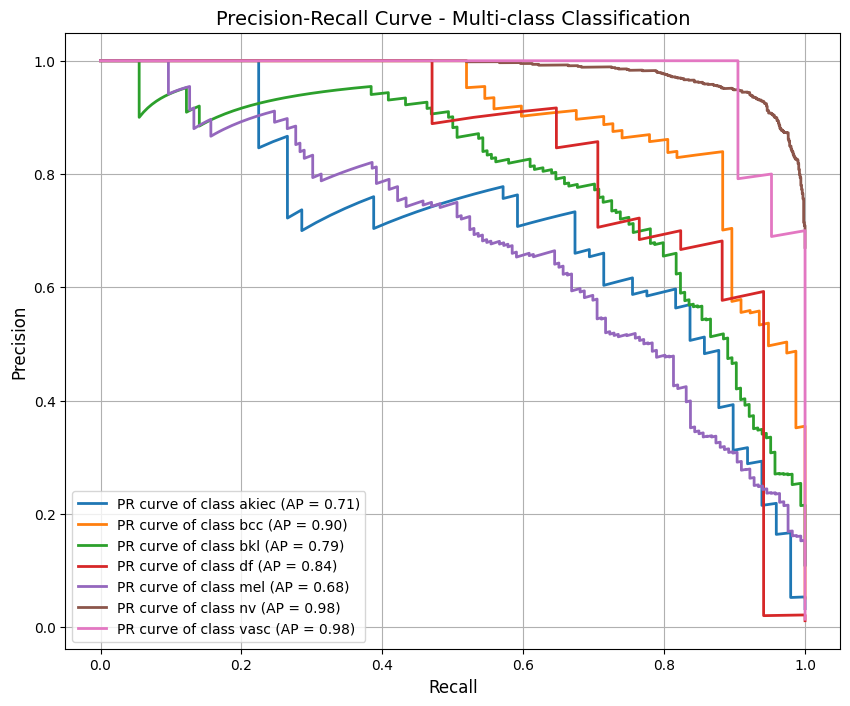

In [17]:
precision = dict()
recall = dict()
average_precision = dict()

for i in range(n_classes):
    precision[i], recall[i], _ = precision_recall_curve(y_test_bin[:, i], y_score[:, i])
    average_precision[i] = average_precision_score(y_test_bin[:, i], y_score[:, i])

plt.figure(figsize=(10, 8))
for i in range(n_classes):
    plt.plot(recall[i], precision[i], lw=2,
             label=f'PR curve of class {class_names[i]} (AP = {average_precision[i]:.2f})')

plt.xlabel("Recall", fontsize=12)
plt.ylabel("Precision", fontsize=12)
plt.title("Precision-Recall Curve - Multi-class Classification", fontsize=14)
plt.legend(loc="lower left", fontsize=10)
plt.grid(True)
plt.show()